In [1]:
# Cell 1: Setup & Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import json
from datetime import datetime

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("  No GPU found! Training will be SLOW.")

# Paths
DATA_DIR = Path("/data/omar/RESEARCH/crosswalk-cctv/data/fpv_processed")
OUTPUT_DIR = Path("/data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n Data: {DATA_DIR}")
print(f" Output: {OUTPUT_DIR}")

 Using device: cuda
   GPU: NVIDIA RTX A6000
   Memory: 50.9 GB

 Data: /data/omar/RESEARCH/crosswalk-cctv/data/fpv_processed
 Output: /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv


In [2]:
# Cell 2: Dataset Class
class CrosswalkDataset(Dataset):
    """FPV Crosswalk Dataset"""
    
    def __init__(self, data_dir, split='train', img_size=512):
        self.data_dir = Path(data_dir)
        self.split = split
        self.img_size = img_size
        
        # Get all images
        self.img_dir = self.data_dir / split / 'images'
        self.mask_dir = self.data_dir / split / 'masks'
        
        self.images = sorted(list(self.img_dir.glob('*.jpg')))
        
        print(f" {split.upper()}: {len(self.images)} samples")
        
        # Transforms
        self.img_transform = T.Compose([
            T.ToTensor(),
            T.Resize((img_size, img_size), antialias=True),
            T.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
        ])
        
        self.mask_transform = T.Compose([
            T.ToTensor(),
            T.Resize((img_size, img_size), antialias=True)
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.images[idx]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask_name = img_path.name.replace('.jpg', '_mask.png')
        mask_path = self.mask_dir / mask_name
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        # Apply transforms
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        
        # Binarize mask (0 or 1)
        mask = (mask > 0.5).float()
        
        return img, mask

# Create datasets
print("🔧 Creating datasets...")
train_dataset = CrosswalkDataset(DATA_DIR, 'train', img_size=512)
val_dataset = CrosswalkDataset(DATA_DIR, 'val', img_size=512)

print(f"\n Datasets created!")

🔧 Creating datasets...
 TRAIN: 2640 samples
 VAL: 330 samples

 Datasets created!


In [3]:
# Cell 3: Data Loaders
BATCH_SIZE = 8  # Adjust based on your GPU memory
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"🔄 Data loaders created:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Test loading
print("\n Testing data loading...")
img, mask = next(iter(train_loader))
print(f"   Image batch: {img.shape}")
print(f"   Mask batch: {mask.shape}")
print(f"    Data loading works!")

🔄 Data loaders created:
   Batch size: 8
   Train batches: 330
   Val batches: 42

 Testing data loading...
   Image batch: torch.Size([8, 3, 512, 512])
   Mask batch: torch.Size([8, 1, 512, 512])
    Data loading works!


In [4]:
# Cell 4: Simple U-Net Model (Lightweight)
class SimpleUNet(nn.Module):
    """Lightweight U-Net for crosswalk segmentation"""
    
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.out = nn.Conv2d(64, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder with skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        out = self.out(d1)
        return torch.sigmoid(out)

# Create model
print("  Building model...")
model = SimpleUNet(in_channels=3, out_channels=1)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f" Model created!")
print(f"   Parameters: {total_params:,} ({total_params/1e6:.1f}M)")

  Building model...
 Model created!
   Parameters: 31,043,521 (31.0M)


In [5]:
# Cell 5: Loss & Optimizer
# Dice Loss (better for segmentation than BCE alone)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

# Combined Loss
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)

criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print(" Loss & Optimizer configured!")
print(f"   Loss: BCE + Dice")
print(f"   Optimizer: Adam (lr=1e-4)")

 Loss & Optimizer configured!
   Loss: BCE + Dice
   Optimizer: Adam (lr=1e-4)


In [11]:
# Cell 6: Training Functions
def calculate_iou(pred, target, threshold=0.5):
    """Calculate IoU metric"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    
    total_loss = 0
    total_iou = 0
    
    pbar = tqdm(loader, desc="Training")
    for imgs, masks in pbar:
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        # Forward
        optimizer.zero_grad()
        preds = model(imgs)
        
        # Loss
        loss = criterion(preds, masks)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        total_iou += calculate_iou(preds.detach(), masks)
        
        # Update progress bar
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    
    return avg_loss, avg_iou

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    
    total_loss = 0
    total_iou = 0
    
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation"):
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            preds = model(imgs)
            loss = criterion(preds, masks)
            
            total_loss += loss.item()
            total_iou += calculate_iou(preds, masks)
    
    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)
    
    return avg_loss, avg_iou

print(" Training functions ready!")

 Training functions ready!


In [12]:
# Cell 7: Visualization Function
def visualize_predictions(model, dataset, device, num_samples=4):
    """Visualize model predictions"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*3))
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get random sample
            idx = np.random.randint(0, len(dataset))
            img, mask = dataset[idx]
            
            # Predict
            img_batch = img.unsqueeze(0).to(device)
            pred = model(img_batch).squeeze().cpu()
            
            # Denormalize image for display
            img_display = img.permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            # Plot
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title("Image")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask.squeeze(), cmap='gray')
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred.squeeze(), cmap='gray')
            axes[i, 2].set_title(f"Prediction")
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

print(" Visualization function ready!")

 Visualization function ready!


 STARTING TRAINING
Epochs: 30
Batch size: 8
Device: cuda


Epoch 1/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 1 Results:
   Train Loss: 0.3719 | Train IoU: 0.8448
   Val Loss:   0.2842 | Val IoU:   0.8805
   LR: 0.000100
    New best model saved! (IoU: 0.8805)

Epoch 2/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 2 Results:
   Train Loss: 0.2234 | Train IoU: 0.8912
   Val Loss:   0.2165 | Val IoU:   0.8945
   LR: 0.000100
    New best model saved! (IoU: 0.8945)

Epoch 3/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 3 Results:
   Train Loss: 0.1822 | Train IoU: 0.9002
   Val Loss:   0.1826 | Val IoU:   0.8938
   LR: 0.000100

Epoch 4/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 4 Results:
   Train Loss: 0.1613 | Train IoU: 0.9058
   Val Loss:   0.1561 | Val IoU:   0.9071
   LR: 0.000100
    New best model saved! (IoU: 0.9071)

Epoch 5/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 5 Results:
   Train Loss: 0.1502 | Train IoU: 0.9096
   Val Loss:   0.1482 | Val IoU:   0.9101
   LR: 0.000100
    New best model saved! (IoU: 0.9101)
    Checkpoint saved!

 Sample predictions:


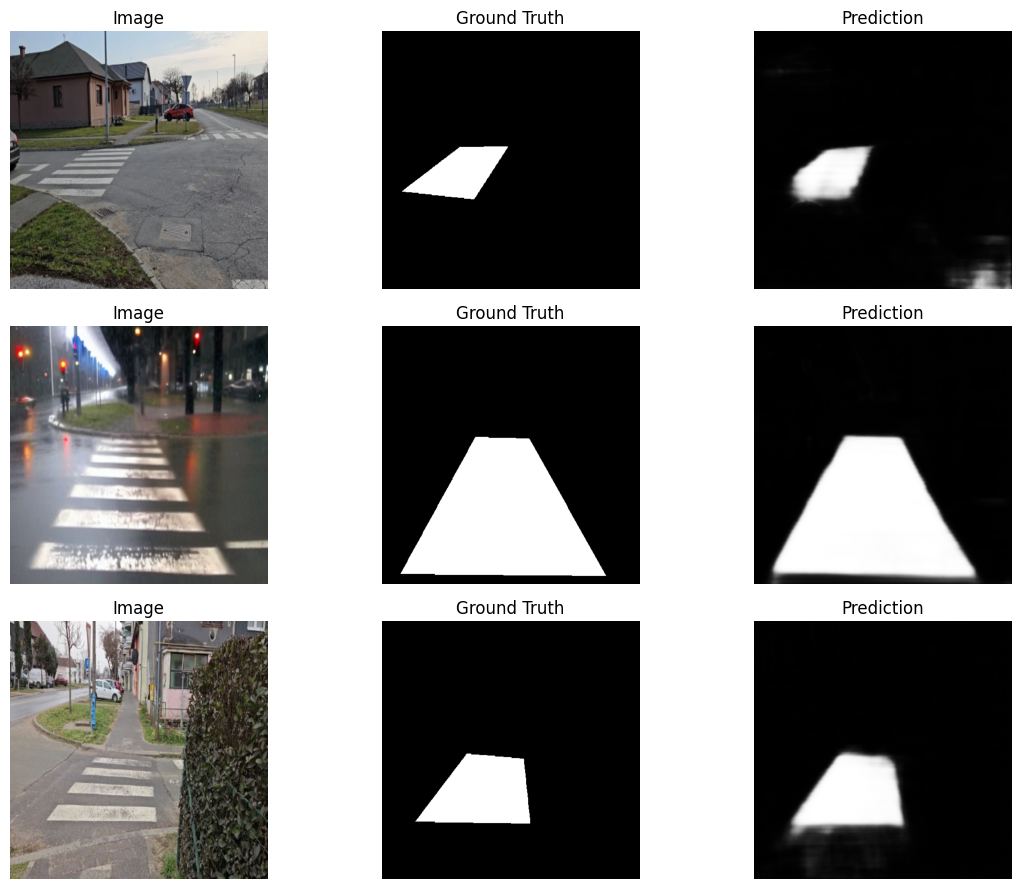


Epoch 6/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 6 Results:
   Train Loss: 0.1437 | Train IoU: 0.9113
   Val Loss:   0.1477 | Val IoU:   0.9072
   LR: 0.000100

Epoch 7/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 7 Results:
   Train Loss: 0.1388 | Train IoU: 0.9137
   Val Loss:   0.1378 | Val IoU:   0.9142
   LR: 0.000100
    New best model saved! (IoU: 0.9142)

Epoch 8/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 8 Results:
   Train Loss: 0.1310 | Train IoU: 0.9172
   Val Loss:   0.1396 | Val IoU:   0.9124
   LR: 0.000100

Epoch 9/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 9 Results:
   Train Loss: 0.1275 | Train IoU: 0.9186
   Val Loss:   0.1345 | Val IoU:   0.9137
   LR: 0.000100

Epoch 10/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 10 Results:
   Train Loss: 0.1239 | Train IoU: 0.9203
   Val Loss:   0.1370 | Val IoU:   0.9132
   LR: 0.000100
    Checkpoint saved!

 Sample predictions:


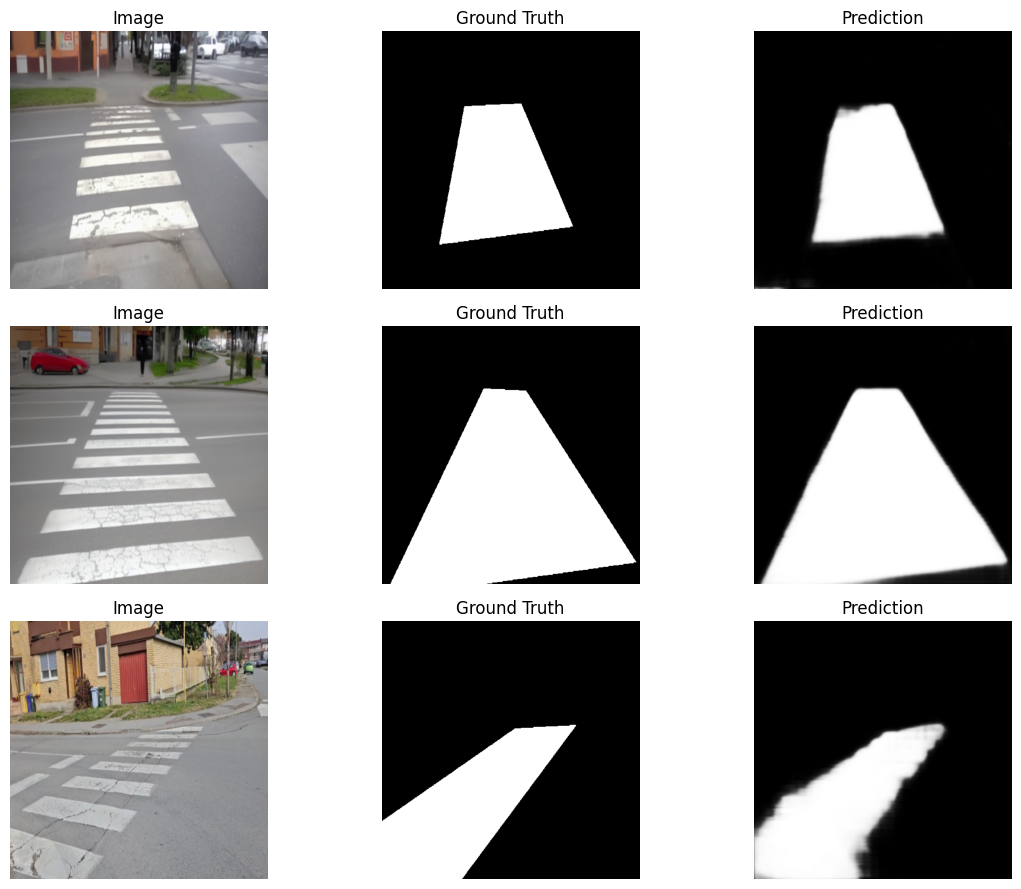


Epoch 11/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 11 Results:
   Train Loss: 0.1203 | Train IoU: 0.9226
   Val Loss:   0.1380 | Val IoU:   0.9116
   LR: 0.000100

Epoch 12/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 12 Results:
   Train Loss: 0.1197 | Train IoU: 0.9225
   Val Loss:   0.1364 | Val IoU:   0.9132
   LR: 0.000100

Epoch 13/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 13 Results:
   Train Loss: 0.1147 | Train IoU: 0.9255
   Val Loss:   0.1390 | Val IoU:   0.9114
   LR: 0.000050

Epoch 14/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 14 Results:
   Train Loss: 0.1049 | Train IoU: 0.9313
   Val Loss:   0.1227 | Val IoU:   0.9219
   LR: 0.000050
    New best model saved! (IoU: 0.9219)

Epoch 15/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 15 Results:
   Train Loss: 0.1009 | Train IoU: 0.9338
   Val Loss:   0.1293 | Val IoU:   0.9150
   LR: 0.000050
    Checkpoint saved!

 Sample predictions:


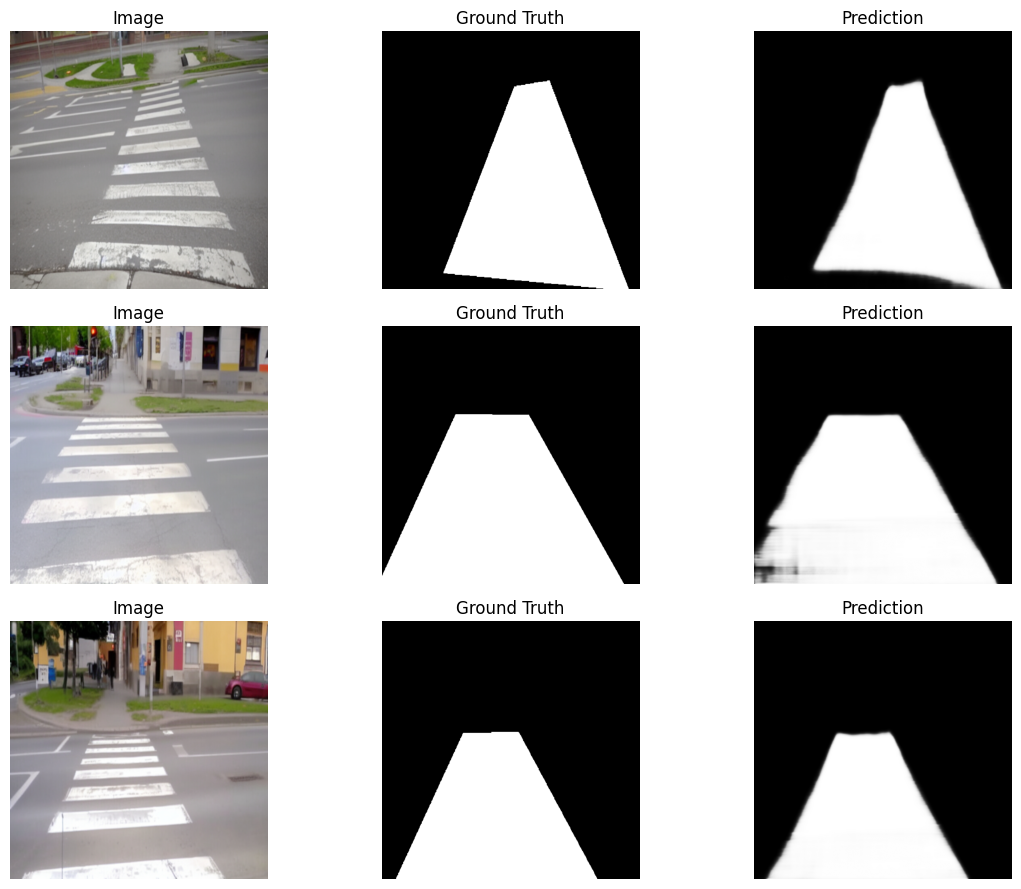


Epoch 16/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 16 Results:
   Train Loss: 0.0981 | Train IoU: 0.9359
   Val Loss:   0.1295 | Val IoU:   0.9172
   LR: 0.000050

Epoch 17/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 17 Results:
   Train Loss: 0.0968 | Train IoU: 0.9363
   Val Loss:   0.1230 | Val IoU:   0.9219
   LR: 0.000050

Epoch 18/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 18 Results:
   Train Loss: 0.0954 | Train IoU: 0.9374
   Val Loss:   0.1284 | Val IoU:   0.9174
   LR: 0.000025

Epoch 19/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 19 Results:
   Train Loss: 0.0876 | Train IoU: 0.9423
   Val Loss:   0.1233 | Val IoU:   0.9234
   LR: 0.000025
    New best model saved! (IoU: 0.9234)

Epoch 20/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 20 Results:
   Train Loss: 0.0850 | Train IoU: 0.9438
   Val Loss:   0.1265 | Val IoU:   0.9190
   LR: 0.000025
    Checkpoint saved!

 Sample predictions:


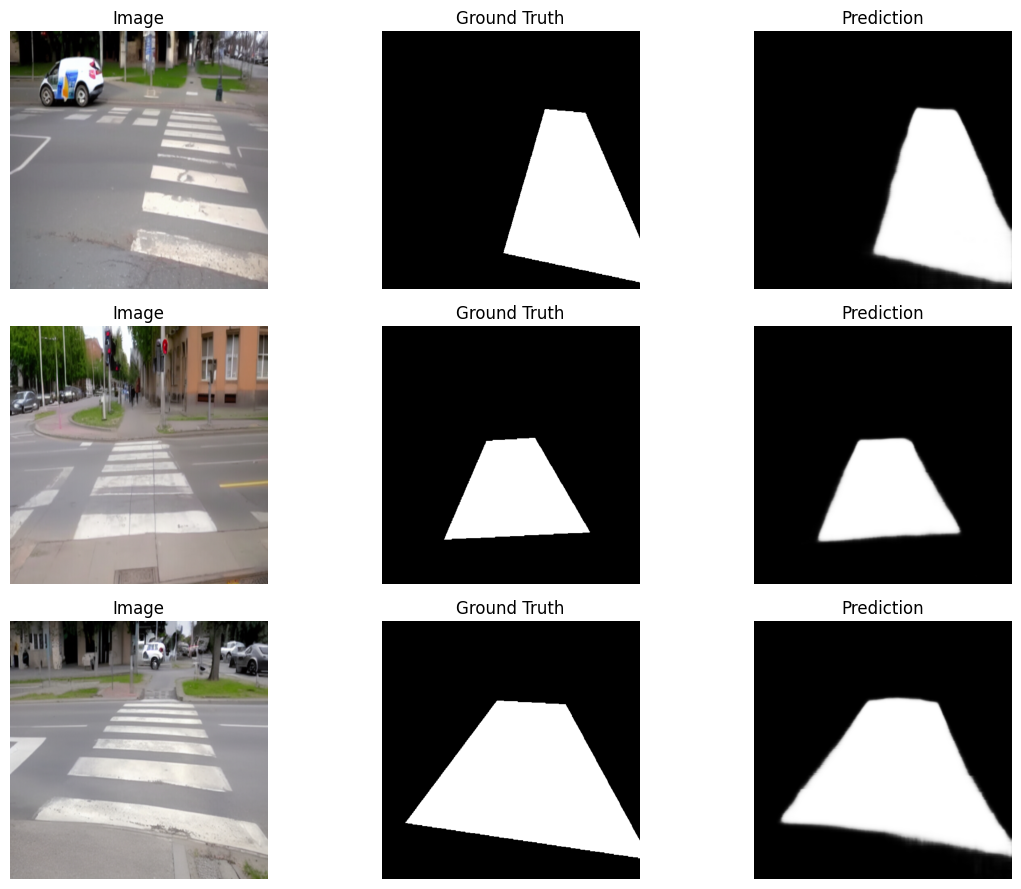


Epoch 21/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 21 Results:
   Train Loss: 0.0821 | Train IoU: 0.9458
   Val Loss:   0.1226 | Val IoU:   0.9244
   LR: 0.000025
    New best model saved! (IoU: 0.9244)

Epoch 22/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 22 Results:
   Train Loss: 0.0813 | Train IoU: 0.9463
   Val Loss:   0.1269 | Val IoU:   0.9210
   LR: 0.000025

Epoch 23/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 23 Results:
   Train Loss: 0.0798 | Train IoU: 0.9472
   Val Loss:   0.1240 | Val IoU:   0.9228
   LR: 0.000025

Epoch 24/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 24 Results:
   Train Loss: 0.0778 | Train IoU: 0.9484
   Val Loss:   0.1301 | Val IoU:   0.9197
   LR: 0.000025

Epoch 25/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 25 Results:
   Train Loss: 0.0755 | Train IoU: 0.9497
   Val Loss:   0.1285 | Val IoU:   0.9220
   LR: 0.000013
    Checkpoint saved!

 Sample predictions:


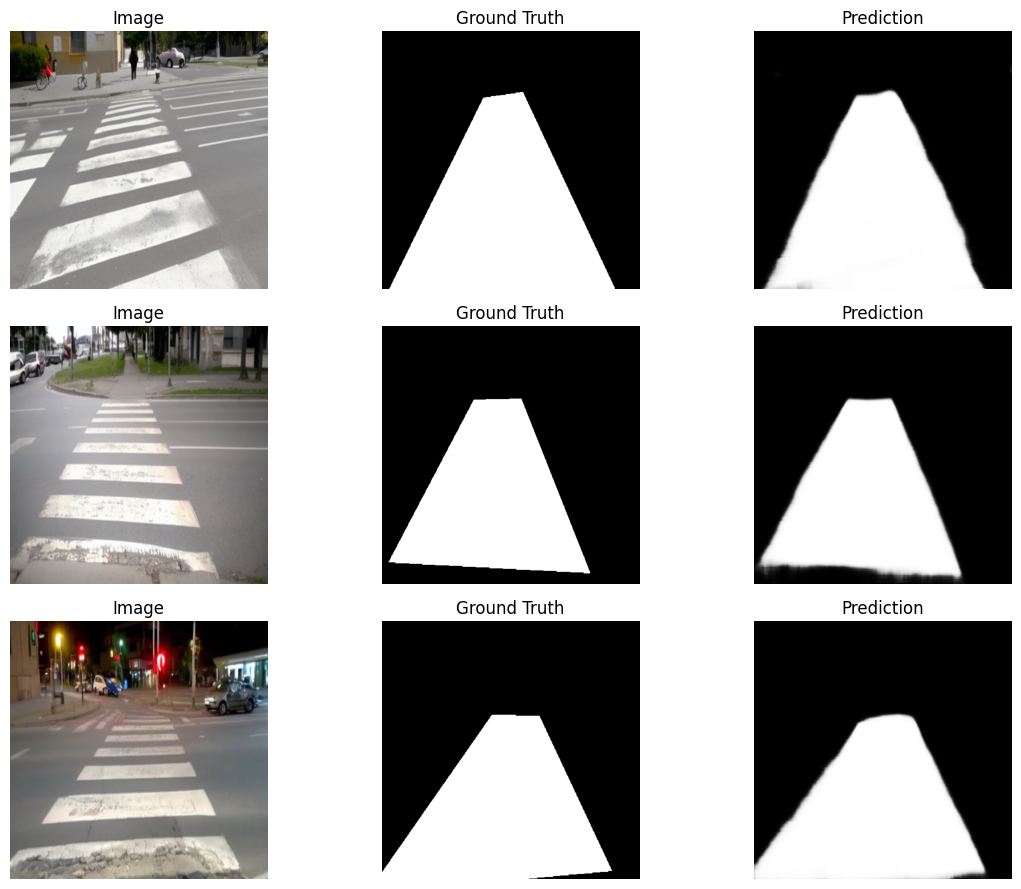


Epoch 26/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 26 Results:
   Train Loss: 0.0712 | Train IoU: 0.9525
   Val Loss:   0.1301 | Val IoU:   0.9223
   LR: 0.000013

Epoch 27/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 27 Results:
   Train Loss: 0.0697 | Train IoU: 0.9535
   Val Loss:   0.1331 | Val IoU:   0.9189
   LR: 0.000013

Epoch 28/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 28 Results:
   Train Loss: 0.0684 | Train IoU: 0.9542
   Val Loss:   0.1313 | Val IoU:   0.9223
   LR: 0.000013

Epoch 29/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 29 Results:
   Train Loss: 0.0674 | Train IoU: 0.9548
   Val Loss:   0.1340 | Val IoU:   0.9220
   LR: 0.000006

Epoch 30/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Epoch 30 Results:
   Train Loss: 0.0646 | Train IoU: 0.9566
   Val Loss:   0.1322 | Val IoU:   0.9224
   LR: 0.000006
    Checkpoint saved!

 Sample predictions:


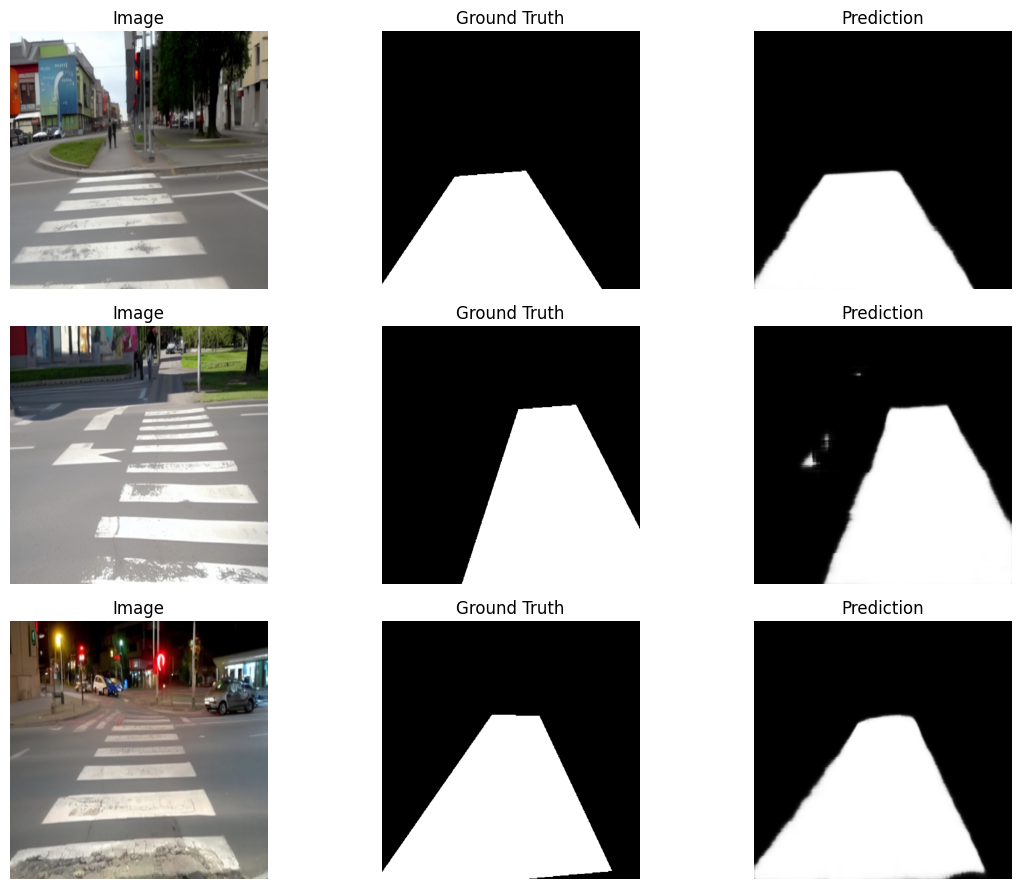


 TRAINING COMPLETE!
Best Val IoU: 0.9244


In [13]:
# Cell 8: Training Loop
NUM_EPOCHS = 30  # Start with 30, can continue later
SAVE_EVERY = 5   # Save checkpoint every N epochs

print("="*60)
print(" STARTING TRAINING")
print("="*60)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {device}")
print()

# Training history
history = {
    'train_loss': [],
    'train_iou': [],
    'val_loss': [],
    'val_iou': [],
}

best_val_iou = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_iou = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_iou = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    
    # Print metrics
    print(f"\n Epoch {epoch+1} Results:")
    print(f"   Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"   Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f}")
    print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
        }, OUTPUT_DIR / 'best_model.pth')
        print(f"    New best model saved! (IoU: {val_iou:.4f})")
    
    # Save checkpoint
    if (epoch + 1) % SAVE_EVERY == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, OUTPUT_DIR / f'checkpoint_epoch{epoch+1}.pth')
        print(f"    Checkpoint saved!")
    
    # Visualize every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\n Sample predictions:")
        visualize_predictions(model, val_dataset, device, num_samples=3)

print("\n" + "="*60)
print(" TRAINING COMPLETE!")
print("="*60)
print(f"Best Val IoU: {best_val_iou:.4f}")

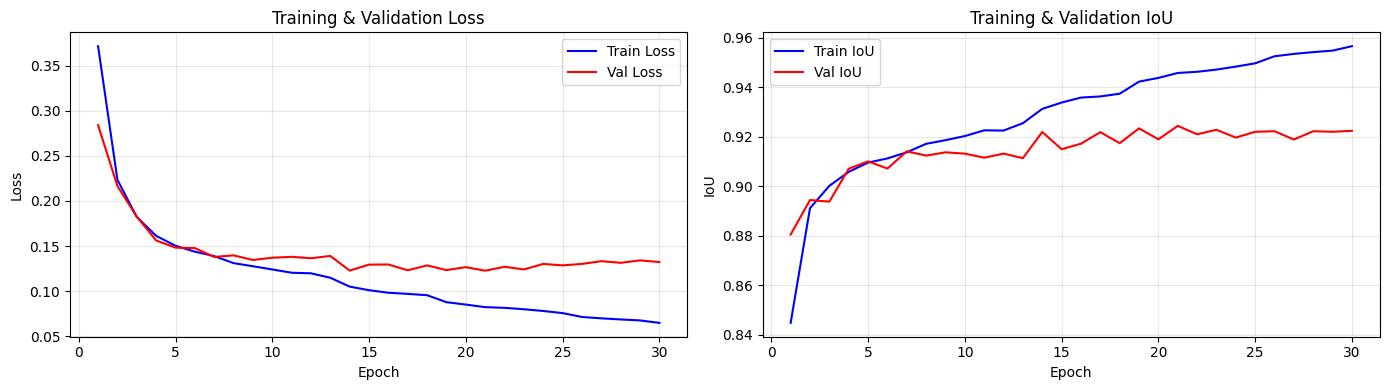

 Training curves saved to /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv/training_history.png


In [14]:
# Cell 9: Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# IoU
ax2.plot(epochs, history['train_iou'], 'b-', label='Train IoU')
ax2.plot(epochs, history['val_iou'], 'r-', label='Val IoU')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('IoU')
ax2.set_title('Training & Validation IoU')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f" Training curves saved to {OUTPUT_DIR / 'training_history.png'}")

 FINAL EVALUATION ON TEST SET
 TEST: 330 samples


Validation:   0%|          | 0/42 [00:00<?, ?it/s]


 Test Results:
   Loss: 0.1096
   IoU:  0.9305

 Test Set Predictions:


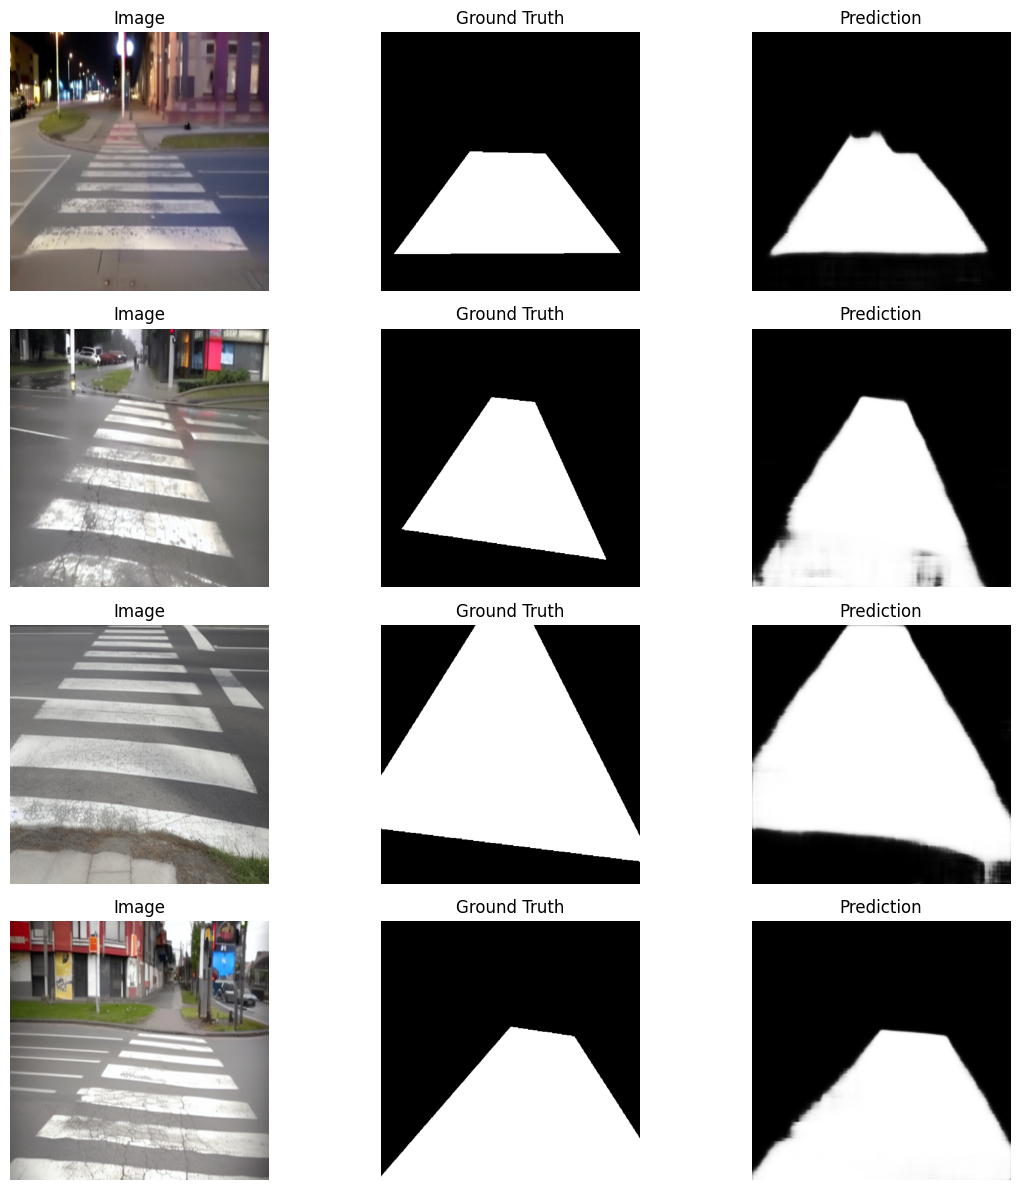


 Results saved to /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv/results.json


In [15]:
# Cell 10: Final Evaluation & Save
# Load best model
checkpoint = torch.load(OUTPUT_DIR / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

print("="*60)
print(" FINAL EVALUATION ON TEST SET")
print("="*60)

# Create test dataset & loader
test_dataset = CrosswalkDataset(DATA_DIR, 'test', img_size=512)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loss, test_iou = validate(model, test_loader, criterion, device)

print(f"\n Test Results:")
print(f"   Loss: {test_loss:.4f}")
print(f"   IoU:  {test_iou:.4f}")

# Visualize test samples
print("\n Test Set Predictions:")
visualize_predictions(model, test_dataset, device, num_samples=4)

# Save final results
results = {
    'best_val_iou': best_val_iou,
    'test_iou': test_iou,
    'test_loss': test_loss,
    'num_epochs': NUM_EPOCHS,
    'history': history,
}

with open(OUTPUT_DIR / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n Results saved to {OUTPUT_DIR / 'results.json'}")

In [16]:
# Cell 11: Summary
print()
print("="*60)
print(" STAGE 1 (FPV PRETRAINING) COMPLETE!")
print("="*60)
print()
print(" Summary:")
print(f"   Training samples: 2,640")
print(f"   Validation samples: 330")
print(f"   Test samples: 330")
print(f"   Epochs trained: {NUM_EPOCHS}")
print(f"   Best Val IoU: {best_val_iou:.4f}")
print(f"   Test IoU: {test_iou:.4f}")
print()
print(" Saved files:")
print(f"   Best model: {OUTPUT_DIR / 'best_model.pth'}")
print(f"   Training curves: {OUTPUT_DIR / 'training_history.png'}")
print(f"   Results: {OUTPUT_DIR / 'results.json'}")
print()
print("="*60)
print(" NEXT STEPS:")
print("="*60)
print()
print("5.  Notebook 05: Test FPV model on CCTV frames")
print("   → See how well (or poorly!) the model transfers")
print("   → Measure the domain gap")
print("   → THIS MOTIVATES STAGE 2!")
print()
print("6.  Notebook 06: Stage 2 - Geometric Self-Supervision")
print("   → Adapt model to CCTV using zebra stripes")
print("   → THE NOVEL RESEARCH CONTRIBUTION!")
print()


 STAGE 1 (FPV PRETRAINING) COMPLETE!

 Summary:
   Training samples: 2,640
   Validation samples: 330
   Test samples: 330
   Epochs trained: 30
   Best Val IoU: 0.9244
   Test IoU: 0.9305

 Saved files:
   Best model: /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv/best_model.pth
   Training curves: /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv/training_history.png
   Results: /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv/results.json

 NEXT STEPS:

5.  Notebook 05: Test FPV model on CCTV frames
   → See how well (or poorly!) the model transfers
   → Measure the domain gap
   → THIS MOTIVATES STAGE 2!

6.  Notebook 06: Stage 2 - Geometric Self-Supervision
   → Adapt model to CCTV using zebra stripes
   → THE NOVEL RESEARCH CONTRIBUTION!

